In [1]:
# 필요한 라이브러리 가져오기
import pandas as pd
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import BaselineOnly
from surprise import SVD
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import train_test_split

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216 from C header, got 232 from PyObject


In [5]:
# 데이터 가져오기
# 북크로싱 데이터
user = pd.read_csv('./data/BX-CSV-Dump/BX-Users.csv', sep=';', error_bad_lines = False, encoding='latin-1')
user.columns = ['userID','Location','Age']
rating = pd.read_csv('./data/BX-CSV-Dump/BX-Book-Ratings.csv', sep=';', error_bad_lines = False, encoding='latin-1')
rating.columns = ['userID','ISBN','bookRating']

In [6]:
# 1. 데이터 확인&합치기 / user 데이터와 rating 데이터들을 head 함수로 확인 후 
# merge 함수를 사용해서 병합해 df 변수에 저장하세요. (on = 'userID', how='inner')
user.head()

,userID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [7]:
rating.head()

,userID,ISBN,bookRating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [8]:
df = pd.merge(user, rating, on='userID', how='inner')
# Location , Age 변수는 삭제하세요 
df.drop(['Location', 'Age'], axis = 1, inplace = True)

df.head() # userID, ISBN , bookRating 변수만 존재하는지 확인 ! 

,userID,ISBN,bookRating
0,2,0195153448,0
1,7,034542252,0
2,8,0002005018,5
3,8,0060973129,0
4,8,0374157065,0


In [11]:
# 메모리 에러를 피하기 위해 저조한 평가를 기록한 도서 및 사용자 제외
# 평점 50개 미만인 도서 및 유저 제거
min_book_ratings = 50 
filter_books = df['ISBN'].value_counts() > min_book_ratings
filter_books = filter_books[filter_books].index.tolist()

min_user_ratings = 50
filter_users = df['userID'].value_counts() > min_user_ratings
filter_users = filter_users[filter_users].index.tolist()

df_new = df[(df['ISBN'].isin(filter_books)) & (df['userID'].isin(filter_users))]
print('원본 데이터 shape',df.shape)
print('new_df 데이터 shape',df_new.shape)

원본 데이터 shape (1149780, 3)
new_df 데이터 shape (140516, 3)


In [17]:
# 2. 데이터 준비 / rating_scale = (0,9) 인 Reader 객체 생성 하기
reader = Reader(rating_scale=(0,9))
data = Dataset.load_from_df(df_new[['userID','ISBN','bookRating']], reader)

# train_test_split 으로 trainset, testset 분리 (test_size=0.25)
trainset,testset = train_test_split(data, test_size=0.25)

In [18]:
# 3. BaselineOnly() 모델을 이용해 데이터 적합 후 rmse 측정 하기
bsl_options = {'method':'als', 'n_epochs':5, 'reg_u':12, 'reg_i':5}
algo = BaselineOnly(bsl_options=bsl_options)
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

Estimating biases using als...
RMSE: 3.3633


3.363292323041578

In [19]:
# 예측 값 살펴보기
def get_Iu(uid):
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError:
        return 0
def get_Ui(iid):
    try:
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0

df = pd.DataFrame(predictions, columns = ['uid','iid','rui','est','details'])
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)

df.head()

,uid,iid,rui,est,details,Iu,Ui,err
0,87746,0684872153,0.0,0.379592,{'was_impossible': False},158,137,0.379592
1,146932,0375726403,8.0,3.397761,{'was_impossible': False},27,117,4.602239
2,102647,0446604658,0.0,3.380016,{'was_impossible': False},84,33,3.380016
3,60337,0553280589,9.0,1.980058,{'was_impossible': False},32,27,7.019942
4,39616,0440222656,0.0,0.590944,{'was_impossible': False},64,189,0.590944


In [21]:
# 4. df를 err을 기준으로 오름차순으로 정렬해 가장 잘 예측한 10개의 결과만 출력하세요
best_predictions = df.sort_values(by='err')[:10]
best_predictions

,uid,iid,rui,est,details,Iu,Ui,err
21464,166123,0446604275,0.0,0.0,{'was_impossible': False},182,46,0.0
25019,127429,0440514428,0.0,0.0,{'was_impossible': False},122,30,0.0
32489,238120,0446530522,0.0,0.0,{'was_impossible': False},322,32,0.0
3283,123790,0971880107,0.0,0.0,{'was_impossible': False},93,640,0.0
19991,245827,002026478X,0.0,0.0,{'was_impossible': False},120,42,0.0
16293,115120,0345413865,0.0,0.0,{'was_impossible': False},223,45,0.0
17785,175003,0515133302,0.0,0.0,{'was_impossible': False},280,44,0.0
812,225810,0553287303,0.0,0.0,{'was_impossible': False},221,35,0.0
11133,262399,0671001701,0.0,0.0,{'was_impossible': False},152,35,0.0
11136,145451,051512317X,0.0,0.0,{'was_impossible': False},157,58,0.0


In [22]:
# 5. df를 err을 기준으로 오름차순으로 정렬 후 가장 잘못 예측한 10개의 결과만 출력하세요
worst_predictions = df.sort_values(by='err')[-10:]
worst_predictions
# 가장 최악의 예측의 경우 31명이 평가했으며 , user 182442가 10점을 줬음에도 0점으로 예측함

,uid,iid,rui,est,details,Iu,Ui,err
17822,217375,0446530522,10.0,0.285756,{'was_impossible': False},242,32,9.714244
31233,245963,0425170349,10.0,0.237965,{'was_impossible': False},136,49,9.762035
1002,200674,0553576925,10.0,0.116655,{'was_impossible': False},144,40,9.883345
28853,40943,0553213172,10.0,0.110656,{'was_impossible': False},127,50,9.889344
22289,40943,0380710722,10.0,0.037141,{'was_impossible': False},127,59,9.962859
23331,263460,0440236851,10.0,0.000000,{'was_impossible': False},62,43,10.000000
29739,186570,0671789422,10.0,0.000000,{'was_impossible': False},113,35,10.000000
21328,238781,0743406184,10.0,0.000000,{'was_impossible': False},194,27,10.000000
27074,227447,0515132268,10.0,0.000000,{'was_impossible': False},294,30,10.000000
1837,182442,0679433740,10.0,0.000000,{'was_impossible': False},40,31,10.000000


<IPython.core.display.Javascript object>


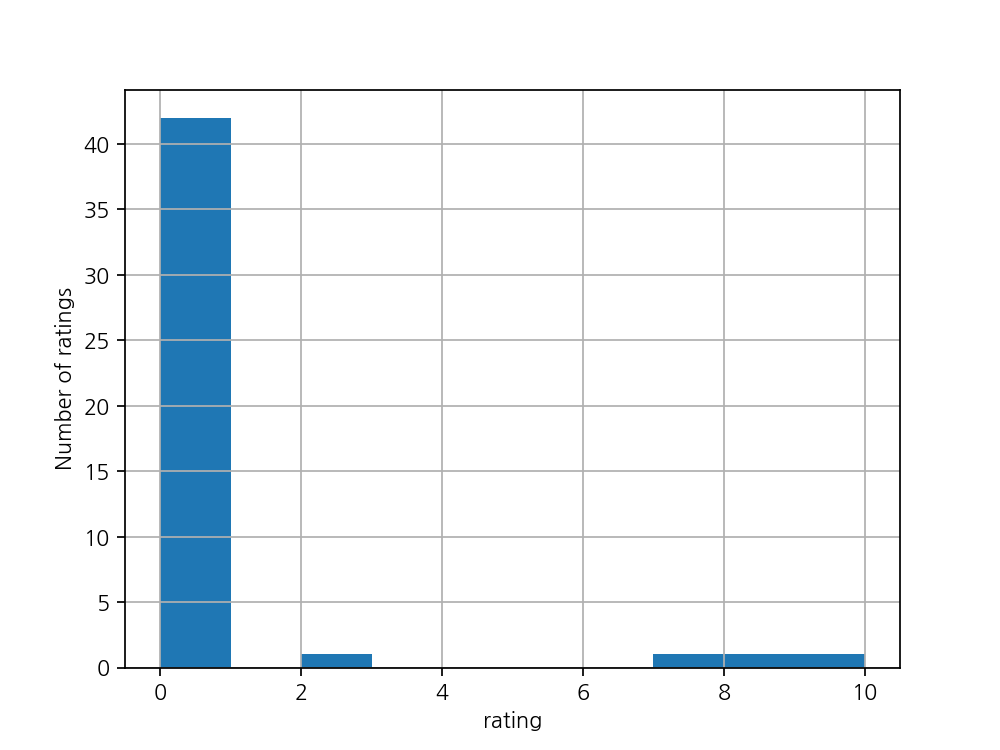

In [23]:
# 0679433740 책에 대한 전체적인 평점 확인
import matplotlib.pyplot as plt
%matplotlib notebook
df_new.loc[df_new['ISBN'] == '0679433740']['bookRating'].hist()
plt.xlabel('rating')
plt.ylabel('Number of ratings')
plt.show()
# 소수의 사용자만이 10점을 줬고 , 대부분의 평점은 0점인 것을 확인할 수 있음